# Provisioning a Cassandra Database

Right out of the box we now how to capacity plan Cassandra

In [1]:
from service_capacity_modeling.interface import CapacityDesires
from service_capacity_modeling.interface import FixedInterval, Interval
from service_capacity_modeling.interface import QueryPattern, DataShape

db_desires = CapacityDesires(
    # This service is critical to the business
    service_tier=1,
    query_pattern=QueryPattern(
        # Not sure exactly how much QPS we will do, but we think around
        # 10,000 reads and 10,000 writes per second.
        estimated_read_per_second=Interval(
            low=1000, mid=10000, high=100000, confidence=0.9
        ),
        estimated_write_per_second=Interval(
            low=1000, mid=10000, high=100000, confidence=0.9
        ),
    ),
    # Not sure how much data, but we think it'll be below 1 TiB
    data_shape=DataShape(
        estimated_state_size_gib=Interval(low=10, mid=100, high=1000, confidence=0.9),
    ),
)

In [2]:
from service_capacity_modeling.capacity_planner import planner
from service_capacity_modeling.models.org import netflix

# Load up the Netflix capacity models
planner.register_group(netflix.models)

cap_plan = planner.plan(
    model_name="org.netflix.cassandra",
    region="us-east-1",
    desires=db_desires,
)

import pprint
def mprint(x):
    pprint.pprint(x.dict(exclude_unset=True), sort_dicts=False)

Loading aws from /home/jolynch/pg/service-capacity-modeling/service_capacity_modeling/hardware/profiles/shapes/aws
Loading /home/jolynch/pg/service-capacity-modeling/service_capacity_modeling/hardware/profiles/pricing/aws/3yr-reserved.json


# An uncertain Capacity plan has a few elements

* `requirement`: The range of requirements
* `least_regret`: The clusters which minimized the models regret function over many simulations.
* `mean`: The clusters that would be provisioned for the average (midpoint) of all intervals.
* `percentiles`: The clusters that would be provisioned assuming various percentiles of the inputs (can use this to generate a "worse case" estimate)

In [3]:
requirement = cap_plan.requirements

lr_opt1, lr_opt1_cost = (
    cap_plan.least_regret[0].candidate_clusters.zonal[0],
    cap_plan.least_regret[0].candidate_clusters.total_annual_cost
)
lr_opt2, lr_opt2_cost = (
    cap_plan.least_regret[1].candidate_clusters.zonal[0],
    cap_plan.least_regret[1].candidate_clusters.total_annual_cost
)
mean_opt, mean_cost = (
    cap_plan.mean[0].candidate_clusters.zonal[0],
    cap_plan.mean[0].candidate_clusters.total_annual_cost
)

In [4]:
mprint(requirement)

{'zonal': [{'requirement_type': 'cassandra-zonal',
            'core_reference_ghz': 2.3,
            'cpu_cores': {'low': 2.0,
                          'mid': 15.0,
                          'high': 75.0,
                          'confidence': 0.9,
                          'minimum_value': 1.0,
                          'maximum_value': 161.0},
            'mem_gib': {'low': 0.0,
                        'mid': 4.0,
                        'high': 75.0,
                        'confidence': 0.9,
                        'minimum_value': 0.0,
                        'maximum_value': 131.0},
            'network_mbps': {'low': 12.0,
                             'mid': 144.0,
                             'high': 904.0,
                             'confidence': 0.9,
                             'minimum_value': 2.0,
                             'maximum_value': 2272.0},
            'disk_gib': {'low': 4.0,
                         'mid': 34.0,
                         'high': 160.0,
   

In [5]:
print("Cluster:",); mprint(lr_opt1)
print("\nRequirement:",); mprint(cap_plan.least_regret[0].requirements.zonal[0])
print(f"\nCost: {lr_opt1_cost}")

Cluster:
{'cluster_type': 'cassandra',
 'count': 2,
 'instance': {'name': 'm5d.2xlarge',
              'cpu': 8,
              'cpu_ghz': 3.1,
              'ram_gib': 32.0,
              'net_mbps': 2000.0,
              'drive': {'name': 'ephem',
                        'size_gib': 300,
                        'read_io_latency_ms': {'low': 0.08,
                                               'mid': 0.12,
                                               'high': 0.2,
                                               'confidence': 0.9}},
              'annual_cost': 1488.6},
 'attached_drives': [],
 'annual_cost': 2977.2,
 'cluster_params': {'cassandra.keyspace.rf': 3}}

Requirement:
{'requirement_type': 'cassandra-zonal',
 'core_reference_ghz': 2.3,
 'cpu_cores': {'low': 11.0, 'mid': 11.0, 'high': 11.0, 'confidence': 1.0},
 'mem_gib': {'low': 1.0, 'mid': 1.0, 'high': 1.0, 'confidence': 1.0},
 'network_mbps': {'low': 546.0, 'mid': 546.0, 'high': 546.0, 'confidence': 1.0},
 'disk_gib': {'low'

In [6]:
print("Cluster:",); mprint(lr_opt2)
print("\nRequirement:",); mprint(cap_plan.least_regret[1].requirements.zonal[0])
print(f"Cost: {lr_opt2_cost}")

Cluster:
{'cluster_type': 'cassandra',
 'count': 4,
 'instance': {'name': 'm5.2xlarge',
              'cpu': 8,
              'cpu_ghz': 3.1,
              'ram_gib': 32.0,
              'net_mbps': 2000.0,
              'drive': None,
              'annual_cost': 1264.6},
 'attached_drives': [{'name': 'gp2',
                      'size_gib': 200,
                      'annual_cost_per_gib': 1.2,
                      'annual_cost_per_read_io': 0,
                      'annual_cost_per_write_io': 0,
                      'read_io_latency_ms': {'low': 1.0,
                                             'mid': 1.1,
                                             'high': 20.0,
                                             'confidence': 0.9},
                      'write_io_latency_ms': {'low': 1.2,
                                              'mid': 2.0,
                                              'high': 30.0,
                                              'confidence': 0.9}}],
 'annual_cost

In [7]:
mprint(mean_opt)
print(mean_cost)

{'cluster_type': 'cassandra',
 'count': 2,
 'instance': {'name': 'm5d.2xlarge',
              'cpu': 8,
              'cpu_ghz': 3.1,
              'ram_gib': 32.0,
              'net_mbps': 2000.0,
              'drive': {'name': 'ephem',
                        'size_gib': 300,
                        'read_io_latency_ms': {'low': 0.08,
                                               'mid': 0.12,
                                               'high': 0.2,
                                               'confidence': 0.9}},
              'annual_cost': 1488.6},
 'attached_drives': [],
 'annual_cost': 2977.2,
 'cluster_params': {'cassandra.keyspace.rf': 3}}
8956.80


# Example 2: Small Dataset + High QPS
In this example we have a more demanding requirement from a RPS and WPS point of view, but we have a lot less data.

**Observe**:
* Increase in compute heavy instance types being deployed to compensate for WPS/RPS requirements

In [8]:
smaller_dataset = CapacityDesires(
    # This service is important to the business, not critical (tier 0)
    service_tier=1,
    query_pattern=QueryPattern(
        # Not sure exactly how much QPS we will do, but we think around
        # 10,000 reads and 10,000 writes per second.
        estimated_read_per_second=Interval(
            low=10_000, mid=100_000, high=1_000_000, confidence=0.9
        ),
        estimated_write_per_second=Interval(
            low=10_000, mid=100_000, high=1_000_000, confidence=0.9
        ),
    ),
    # Not sure how much data, but we think it'll be below 1 TiB
    data_shape=DataShape(
        estimated_state_size_gib=Interval(low=10, mid=100, high=200, confidence=0.9),
    ),
)

cap_plan = planner.plan(
    model_name="org.netflix.cassandra",
    region="us-east-1",
    desires=smaller_dataset,
)

requirement = cap_plan.requirements

lr_opt1, lr_opt1_cost = (
    cap_plan.least_regret[0].candidate_clusters.zonal[0],
    cap_plan.least_regret[0].candidate_clusters.total_annual_cost
)
lr_opt2, lr_opt2_cost = (
    cap_plan.least_regret[1].candidate_clusters.zonal[0],
    cap_plan.least_regret[1].candidate_clusters.total_annual_cost
)
mean_opt, mean_cost = (
    cap_plan.mean[0].candidate_clusters.zonal[0],
    cap_plan.mean[0].candidate_clusters.total_annual_cost
)

print("Cluster:",); mprint(lr_opt1)
print(f"Cost: {lr_opt1_cost}")

Cluster:
{'cluster_type': 'cassandra',
 'count': 16,
 'instance': {'name': 'm5d.2xlarge',
              'cpu': 8,
              'cpu_ghz': 3.1,
              'ram_gib': 32.0,
              'net_mbps': 2000.0,
              'drive': {'name': 'ephem',
                        'size_gib': 300,
                        'read_io_latency_ms': {'low': 0.08,
                                               'mid': 0.12,
                                               'high': 0.2,
                                               'confidence': 0.9}},
              'annual_cost': 1488.6},
 'attached_drives': [],
 'annual_cost': 23817.6,
 'cluster_params': {'cassandra.keyspace.rf': 3}}
Cost: 71475.48


In [9]:
print("Cluster:",); mprint(lr_opt2)
print(f"Cost: {lr_opt2_cost}")

Cluster:
{'cluster_type': 'cassandra',
 'count': 16,
 'instance': {'name': 'm5.2xlarge',
              'cpu': 8,
              'cpu_ghz': 3.1,
              'ram_gib': 32.0,
              'net_mbps': 2000.0,
              'drive': None,
              'annual_cost': 1264.6},
 'attached_drives': [{'name': 'gp2',
                      'size_gib': 2400,
                      'annual_cost_per_gib': 1.2,
                      'annual_cost_per_read_io': 0,
                      'annual_cost_per_write_io': 0,
                      'read_io_latency_ms': {'low': 1.0,
                                             'mid': 1.1,
                                             'high': 20.0,
                                             'confidence': 0.9},
                      'write_io_latency_ms': {'low': 1.2,
                                              'mid': 2.0,
                                              'high': 30.0,
                                              'confidence': 0.9}}],
 'annual_co

# Example 3: Large Dataset + High QPS
In this example we have a more demanding requirement from data perspective.

**Observe**:
* The move to storage dense instance type (i3) as it compensates for the disk footprint increases.

In [10]:
larger_dataset = CapacityDesires(
    # This service is important to the business, not critical (tier 0)
    service_tier=1,
    query_pattern=QueryPattern(
        # Not sure exactly how much QPS we will do, but we think around
        # 10,000 reads and 10,000 writes per second.
        estimated_read_per_second=Interval(
            low=1_000, mid=10_000, high=100_000, confidence=0.9
        ),
        estimated_write_per_second=Interval(
            low=1_000, mid=10_000, high=100_000, confidence=0.9
        ),
    ),
    # Not sure how much data, but we think it'll be below 100 TiB
    data_shape=DataShape(
        estimated_state_size_gib=Interval(low=1_000, mid=10_000, high=100_000, confidence=0.9),
    ),
)

cap_plan = planner.plan(
    model_name="org.netflix.cassandra",
    region="us-east-1",
    desires=larger_dataset,
    require_local_disks=False,
)

requirement = cap_plan.requirements

lr_opt1, lr_opt1_cost = (
    cap_plan.least_regret[0].candidate_clusters.zonal[0],
    cap_plan.least_regret[0].candidate_clusters.total_annual_cost
)

print("Cluster:",); mprint(lr_opt1)
print(f"Cost: {lr_opt1_cost}")
print("\nRequirement:",); mprint(cap_plan.least_regret[0].requirements.zonal[0])


Cluster:
{'cluster_type': 'cassandra',
 'count': 8,
 'instance': {'name': 'i3en.2xlarge',
              'cpu': 8,
              'cpu_ghz': 3.1,
              'ram_gib': 64.0,
              'net_mbps': 8000.0,
              'drive': {'name': 'ephem',
                        'size_gib': 5000,
                        'read_io_latency_ms': {'low': 0.08,
                                               'mid': 0.12,
                                               'high': 0.2,
                                               'confidence': 0.9}},
              'annual_cost': 2999.0},
 'attached_drives': [],
 'annual_cost': 23992.0,
 'cluster_params': {'cassandra.keyspace.rf': 3}}
Cost: 73126.38

Requirement:
{'requirement_type': 'cassandra-zonal',
 'core_reference_ghz': 2.3,
 'cpu_cores': {'low': 28.0, 'mid': 28.0, 'high': 28.0, 'confidence': 1.0},
 'mem_gib': {'low': 45.0, 'mid': 45.0, 'high': 45.0, 'confidence': 1.0},
 'network_mbps': {'low': 60.0, 'mid': 60.0, 'high': 60.0, 'confidence': 1.0},
 

# Example 4: Large Dataset + High QPS - Reduced Durability and Consistency
In this example we have a more demanding requirement from data perspective, but a less demanding requirement from
a consistency and durability perspective

**Observe**:
* The planner moves to RF=2 from RF=3 due to lower durability requirement.
* We switch to compute + *EBS* due to the high per node footprint


In [11]:
from service_capacity_modeling.interface import GlobalConsistency
from service_capacity_modeling.interface import Consistency
from service_capacity_modeling.interface import AccessConsistency
from service_capacity_modeling.interface import FixedInterval

# Write once read never datasets, aka logs or tracing.
worn = CapacityDesires(
    # This service is important to the business, not critical (tier 0)
    service_tier=1,
    query_pattern=QueryPattern(
        estimated_read_per_second=Interval(
            low=10, mid=100, high=1000, confidence=0.9
        ),
        estimated_write_per_second=Interval(
            low=10_000, mid=100_000, high=1_000_000, confidence=0.9
        ),
        # We are ok with eventual consistency on access
        access_consistency=GlobalConsistency(
            same_region=Consistency(
                target_consistency=AccessConsistency.eventual
            )
        ),
    ),
    # Not sure how much data, but we think it'll be below 200 TiB
    data_shape=DataShape(
        estimated_state_size_gib=Interval(low=10_000, mid=100_000, high=200_000, confidence=0.9),
        durability_slo_order=FixedInterval(low=10, mid=100, high=100000),
    ),
)

cap_plan = planner.plan(
    model_name="org.netflix.cassandra",
    region="us-east-1",
    desires=worn,
)

requirement = cap_plan.requirements

lr_opt1, lr_opt1_cost = (
    cap_plan.least_regret[0].candidate_clusters.zonal[0],
    cap_plan.least_regret[0].candidate_clusters.total_annual_cost
)

print("Requirement:",); mprint(cap_plan.least_regret[0].requirements.zonal[0],)
print("Cluster:",); mprint(lr_opt1)
print(f"Cost: {lr_opt1_cost}")

Requirement:
{'requirement_type': 'cassandra-zonal',
 'core_reference_ghz': 2.3,
 'cpu_cores': {'low': 158.0, 'mid': 158.0, 'high': 158.0, 'confidence': 1.0},
 'mem_gib': {'low': 713.0, 'mid': 713.0, 'high': 713.0, 'confidence': 1.0},
 'network_mbps': {'low': 428.0, 'mid': 428.0, 'high': 428.0, 'confidence': 1.0},
 'disk_gib': {'low': 59492.0,
              'mid': 59492.0,
              'high': 59492.0,
              'confidence': 1.0},
 'context': {'working_set': 0.012,
             'rps_working_set': 0.012,
             'disk_slo_working_set': 0.5268451793482459,
             'replication_factor': 2,
             'compression_ratio': 0.38,
             'read_per_second': 70.0}}
Cluster:
{'cluster_type': 'cassandra',
 'count': 16,
 'instance': {'name': 'r5.2xlarge',
              'cpu': 8,
              'cpu_ghz': 3.1,
              'ram_gib': 64.0,
              'net_mbps': 2000.0,
              'drive': None,
              'annual_cost': 1660.0},
 'attached_drives': [{'name': 'gp2',

# Modeling Intervals
The key to the capacity planner is going from intervals such as `my RPS will be within an order of magnitude of 10,000 per second` to a generative probability distribution that is skewed. We represent these with `Intervals` which have a `low`, `mid` and `high`. For example:

```
rps = Interval(low=1_000, mid=10_000, high=100_000, confidence=0.9)
```

Under the hood we do this by solving a numerical set of equations for the [gamma](https://en.wikipedia.org/wiki/Gamma_distribution#:~:text=The%20gamma%20distribution%20is%20the,%CF%88%20is%20the%20digamma%20function) distribution and fitting to the summary statistics.

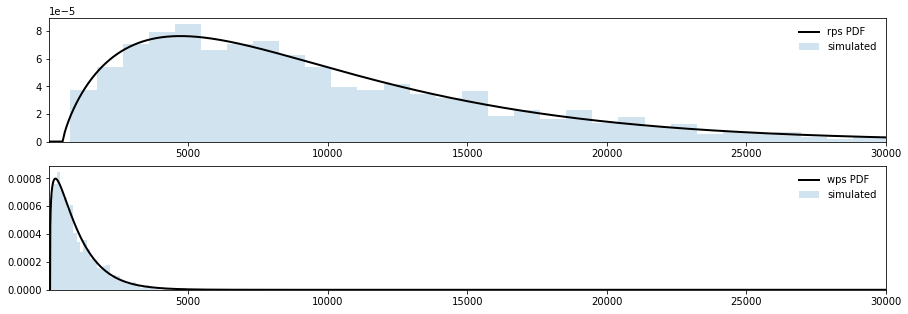

In [12]:
from service_capacity_modeling.stats import gamma_for_interval
import matplotlib.pyplot as plt
import numpy as np

rps = Interval(low=1_000, mid=10_000, high=100_000, confidence=0.9)
wps = Interval(low=100, mid=1_000, high=2_000, confidence=0.9)

rps_gamma = gamma_for_interval(rps)
wps_gamma = gamma_for_interval(wps)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,5))
ax1.ticklabel_format(useOffset=False)

x = np.linspace(10, 40_000, 10000)

# First RPS
ax1.plot(x, rps_gamma.pdf(x), 'k-', lw=2, label='rps PDF')

r = rps_gamma.rvs(size=1028)
ax1.hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=50, label="simulated")
ax1.legend(loc='best', frameon=False)
ax1.set_xlim(5, 30_000)

# Now WPS
ax2.plot(x, wps_gamma.pdf(x), 'k-', lw=2, label='wps PDF')

r = wps_gamma.rvs(size=1028)
ax2.hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=50, label="simulated")
ax2.legend(loc='best', frameon=False)
ax2.set_xlim(5, 30_000)


plt.show()

# Key Insight: Skew Matters

Physical processes skew left and skew right, and we need to be able to represent that. Luckily we can!

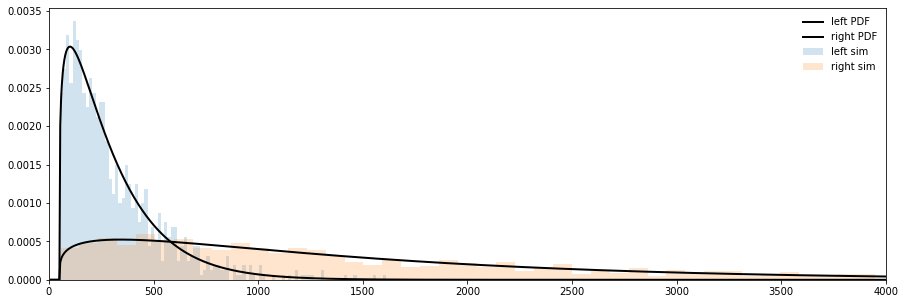

In [13]:
left_skew = Interval(low=100, mid=300, high=2000, confidence=0.9)
right_skew = Interval(low=100, mid=1500, high=2000, confidence=0.9)

left_gamma = gamma_for_interval(left_skew)
right_gamma = gamma_for_interval(right_skew)

fig, ax = plt.subplots(1, 1, figsize=(15,5))

x = np.linspace(10, 4000, 1000)

# Now right skew
ax.plot(x, left_gamma.pdf(x), 'k-', lw=2, label='left PDF')
ax.plot(x, right_gamma.pdf(x), 'k-', lw=2, label='right PDF')

ax.hist(left_gamma.rvs(size=1028), density=True, histtype='stepfilled', alpha=0.2, bins=100, label="left sim")
ax.hist(right_gamma.rvs(size=1028), density=True, histtype='stepfilled', alpha=0.2, bins=100, label="right sim")

ax.legend(loc='best', frameon=False)
ax.set_xlim(0.0, 4000)

plt.show()